In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
from numba import autojit
from pylab import *
from matplotlib import gridspec
import netCDF4
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
tau = ['4', '8', '16']
#tau = ['50', '250', '500' , '1000', '2000']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'CDT/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

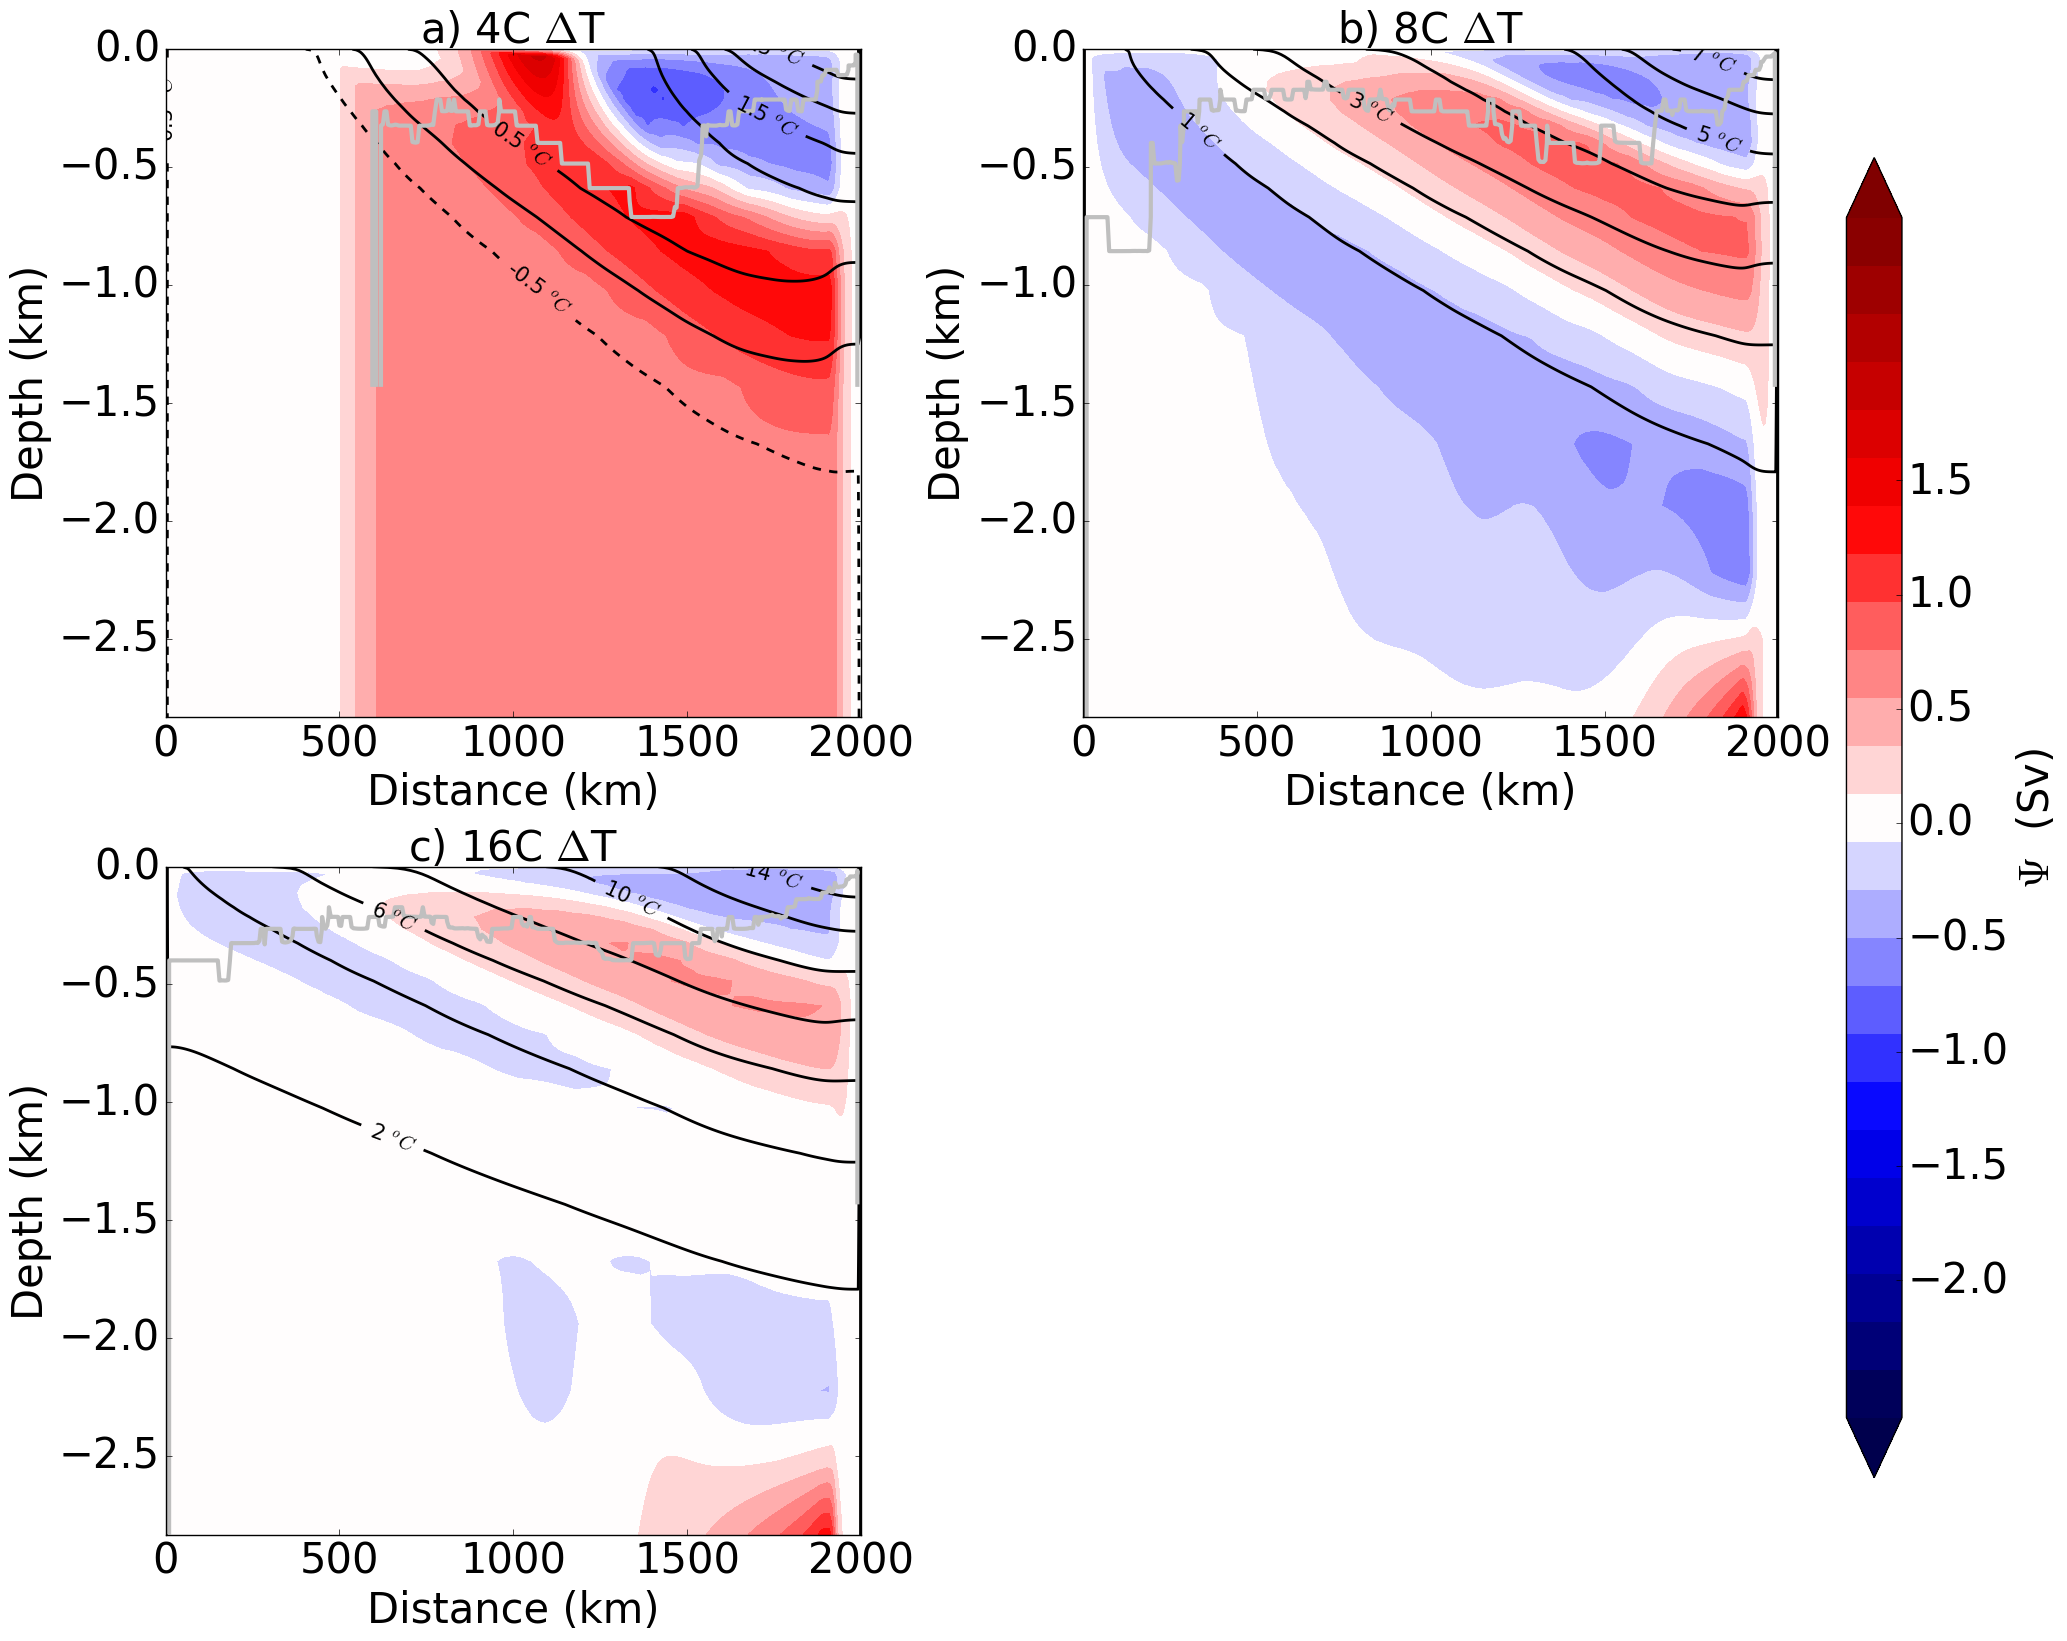

In [3]:
fig = plt.figure(figsize=(18.5, 16.5))
# Create Panels
Psi_levs = np.arange(-2.6, 2.7, .21)
Psi_ticks =np.arange(-2., 2., .5)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = np.arange(-0.5,4.5,0.5),np.arange(-1,8,1),np.arange(-2,16,2),np.arange(-1,8,1),arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS

    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    PIz[-5::,50::]=np.nan
    ax = fig.add_subplot(2, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                Psi, Psi_levs, cmap=plt.cm.seismic, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    r = ax.contour(c.yg/1000,c.zc/1000, PIz,[0.99999999], colors='0.75', linewidths=3)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'C $\Delta $T', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

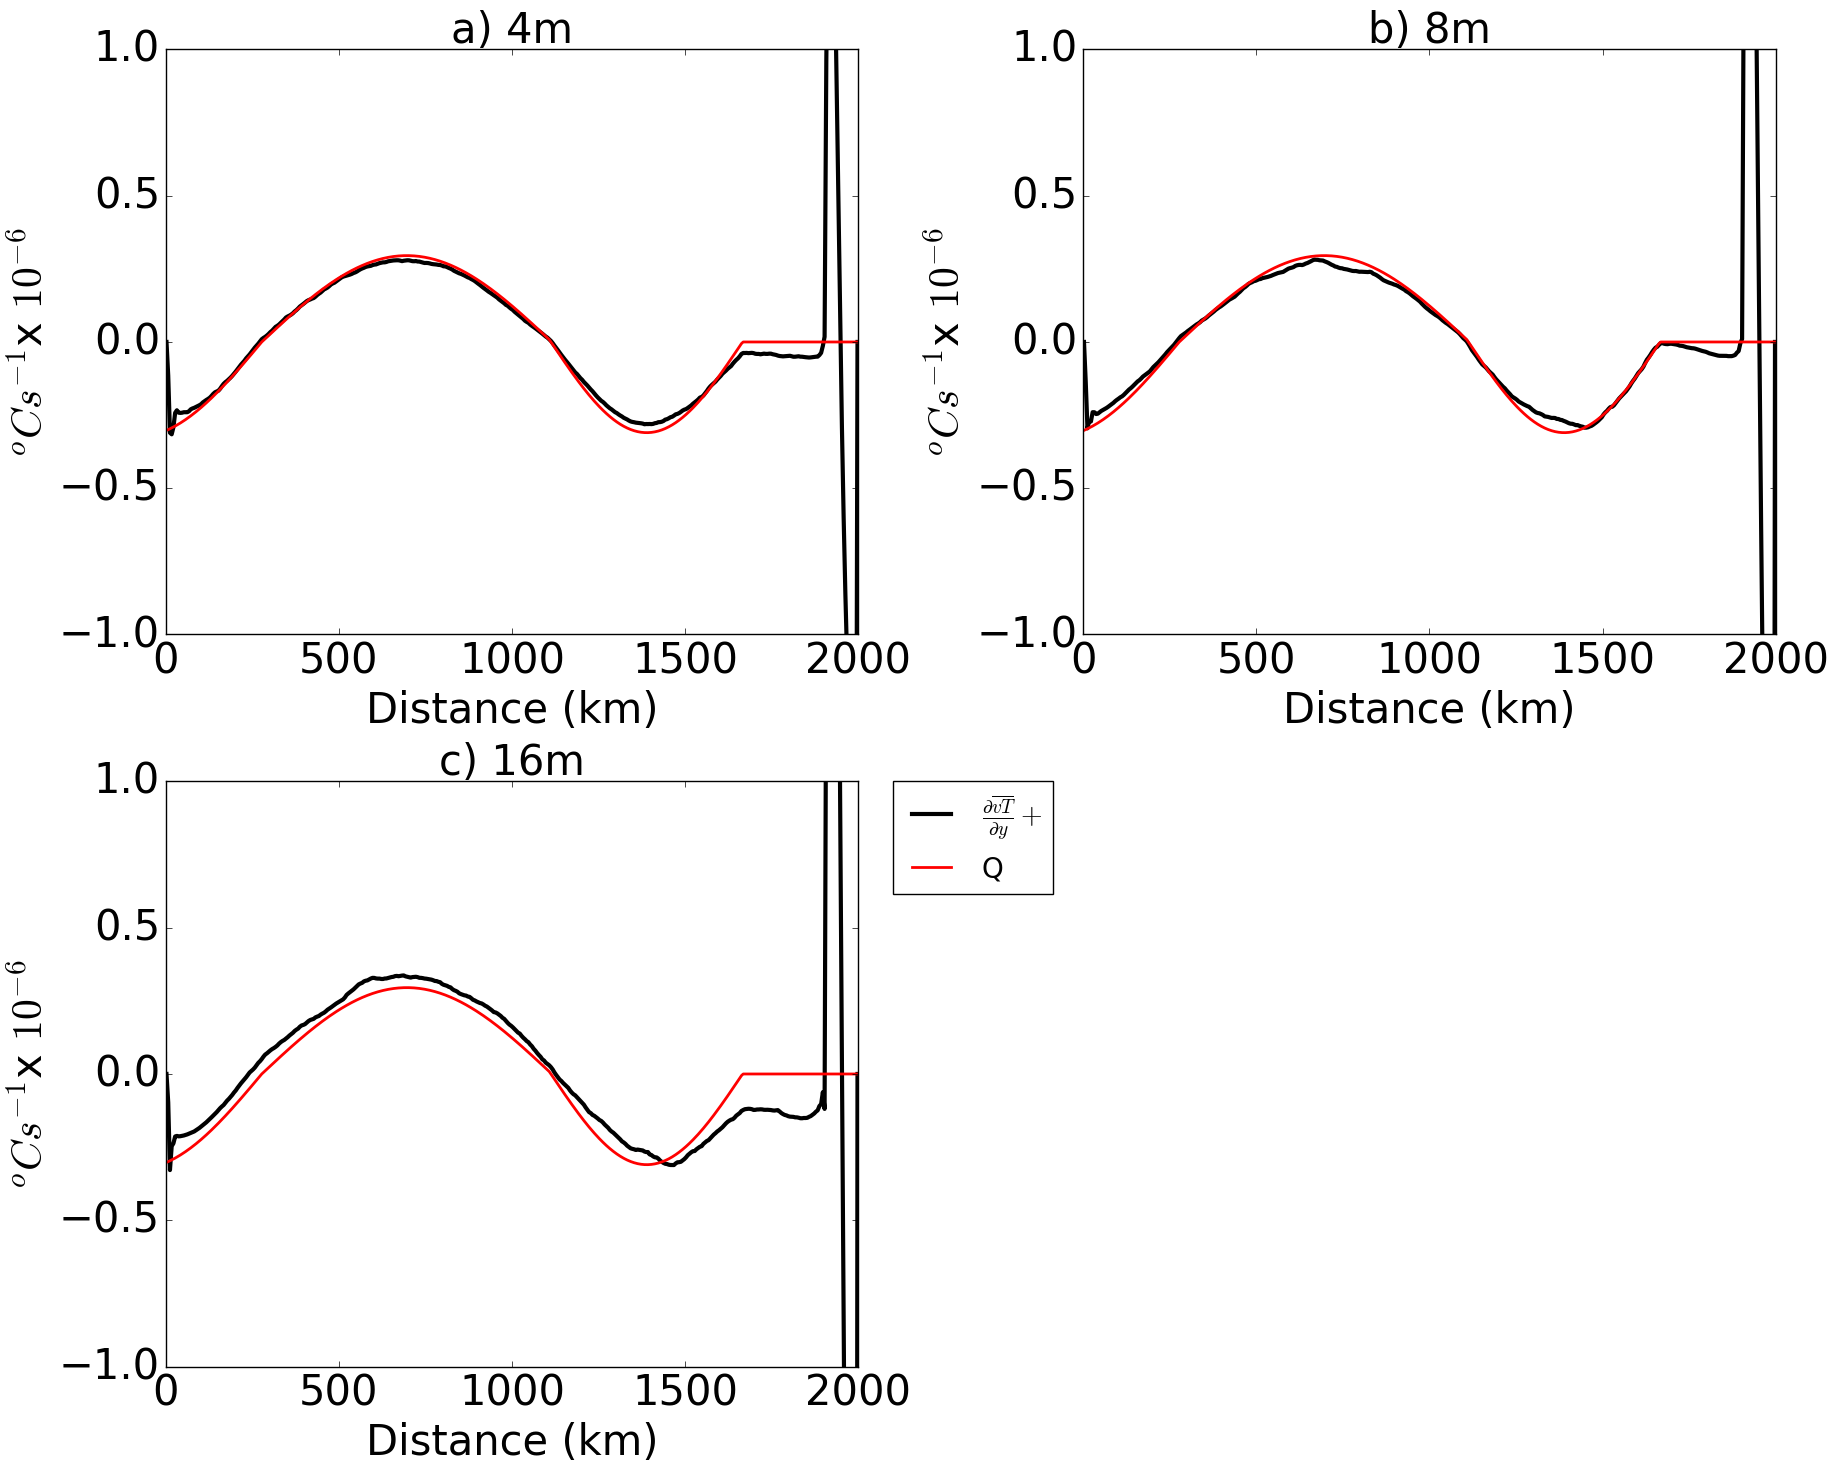

In [64]:
fig = plt.figure(figsize=(18.5, 28.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    Nx, Ny, Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar
    # put everything on the C Grid
    VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    npad = ((1, 0), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    #WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    WTHMASS = 0
    # Surface cor
    Surcor = 0 #(WTHMASS.mean(axis=0)).mean(axis=1)
    dVT = (VT[:, 0:-1, :]-VT[:, 1::, :])*CellVol
    dWT = (WT[1::, :, :]-WT[0:-1, :, :])*CellVol
    Adv = (dVT.sum(axis=0) + dWT.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    #Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(4, 2, i+1)
    p = plt.plot(c.yc/1000, (Diff+Surcor)*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, (Psipred/8.5)*10**6, 'r', linewidth=2)
    plt.ylim(-1, 1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'$\frac{\partial  \overline{vT}}{\partial y} +'
                  + ' \frac{\partial  \overline{wT}}{\partial z}$', 'Q'],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 fontsize=20)
plt.tight_layout()

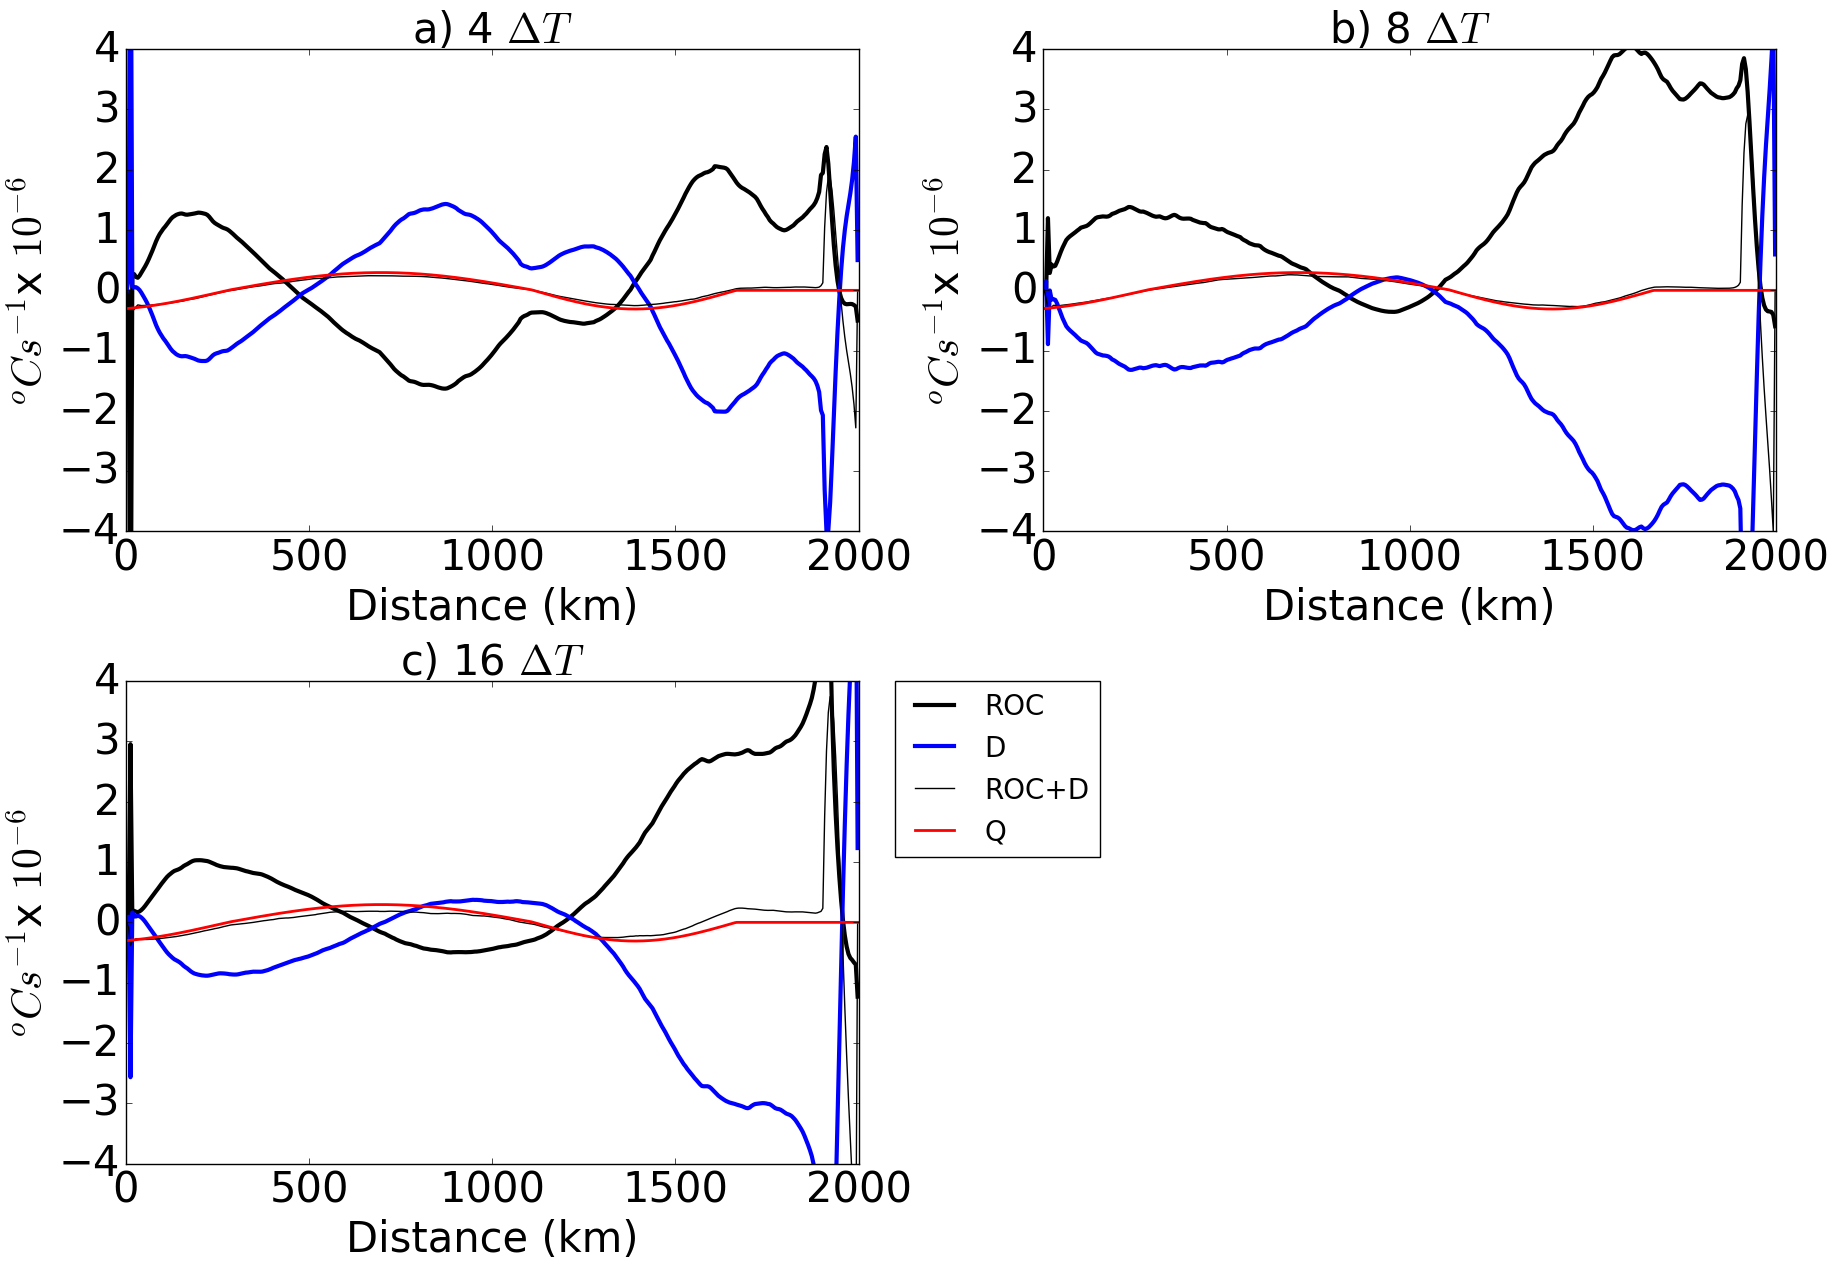

In [65]:
fig = plt.figure(figsize=(18.5, 24.5))
ROCT = []
DE = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf, (c.Nx, c.Ny, 1)).T
    Nx, Ny, Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar
    # put everything on the C Grid
    VT = (c.mnc('Tav_VT.nc', 'VVELTH'))
    WT = (c.mnc('Tav_VT.nc', 'WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc', 'THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc', 'THETA'))
    Ty = (Tv[:, 0:-1, :] - Tv[:, 1::, :])*CellVol
    Tz = (Tw[1::, :, :] - Tw[0:-1, :, :])*CellVol
    npad = ((1, 0), (0, 0), (0, 0))
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    g = layers_calc_numba.LayersComputer(c)
    # ROC
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy), axis=0)/np.sum(CellVol.mean(axis=2))
    # Diabatic eddis from new def
    dx = 5000
    nx = c.Nx
    Dz = (dx*((WT[1::, :, :]-WT[0:-1, :, :])*CellVol).mean(axis=2)/nx -
             c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000))
    Dy = (dx*((VT[:, 1::, :]-VT[:, 0:-1, :])*CellVol).mean(axis=2)/nx -
             c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000))
    D = np.sum((Dz+Dy), axis=0)/np.sum(CellVol.mean(axis=2))
    Psipred = -(Q)/(1000*3985)
        
    if i == 0:
        ROC0 = np.sum(abs(ROC))
        DE0 = np.sum(abs(D))
    ROCT.append((np.sum(abs(ROC))-ROC0)/ROC0)
    DE.append((np.sum(abs(D))-DE0)/DE0)
    ax = fig.add_subplot(4, 2, i+1)

    p = plt.plot(c.yc/1000, -ROC*10**6, 'k', linewidth=3)
    p = plt.plot(c.yc/1000, (-D)*10**6, 'b', linewidth=3)
    p = plt.plot(c.yc/1000, (D+ROC+Surcor)*10**6, 'k', linewidth=1)
    p = plt.plot(c.yc/1000, (-Psipred/8.5)*10**6, 'r', linewidth=2)
    plt.ylim(-4, 4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' $\Delta T$', fontsize=30)

    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'ROC', 'D', 'ROC+D', 'Q'], bbox_to_anchor=(1.05, 1),
                 loc=2, borderaxespad=0., fontsize=20)

plt.tight_layout()


/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in less


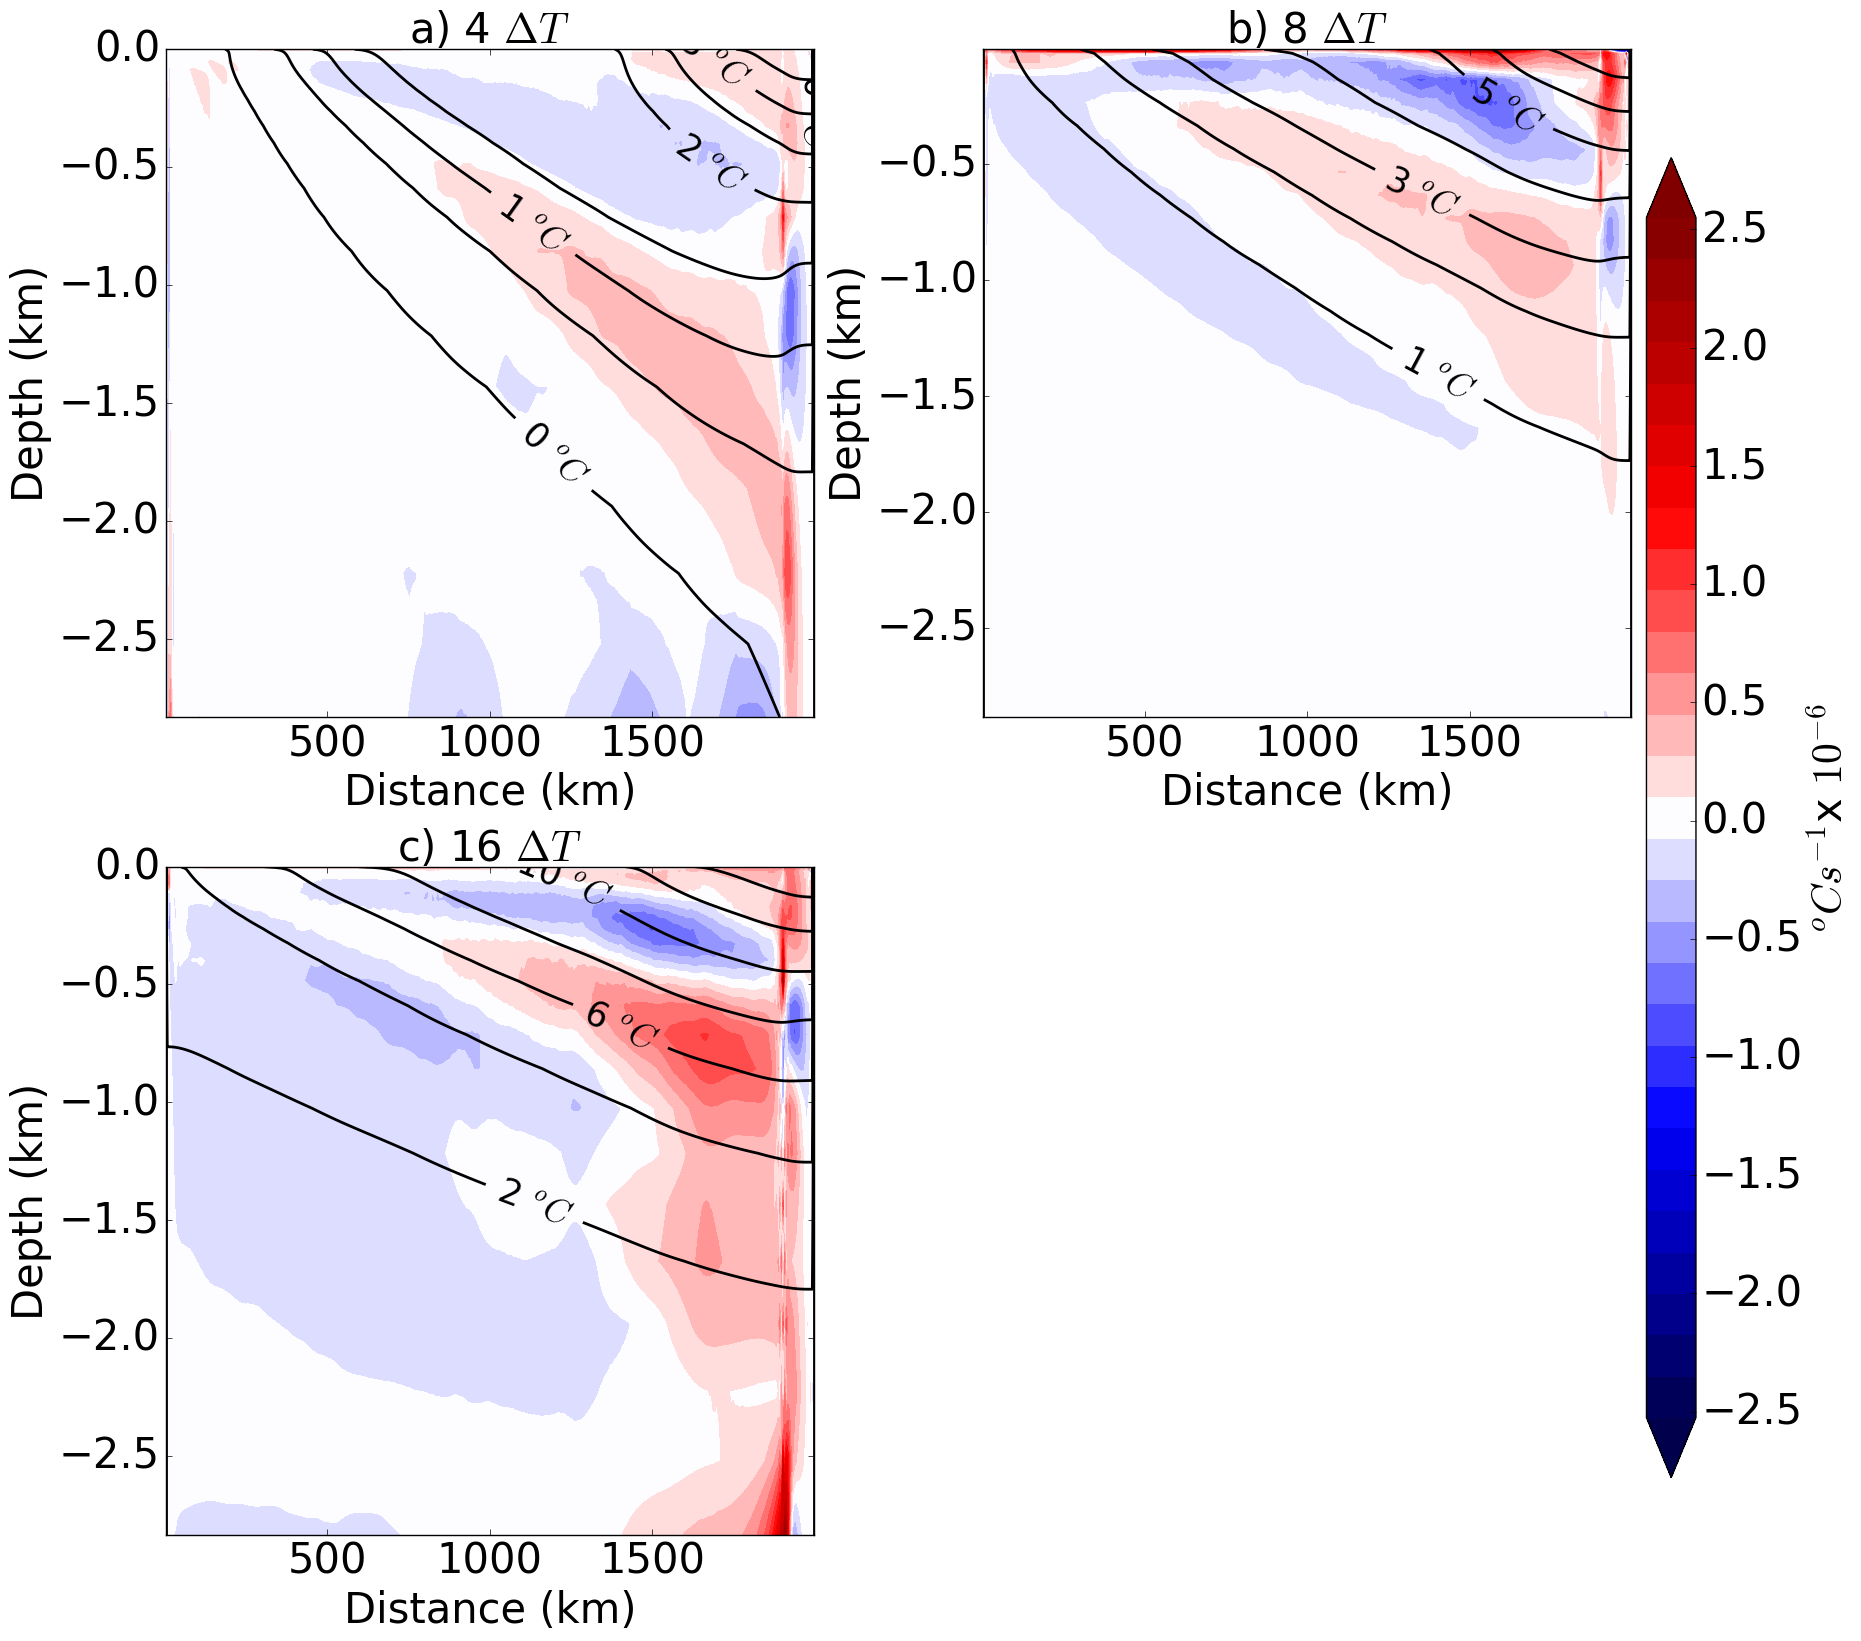

In [66]:
fig = plt.figure(figsize=(16.5, 16.5))
t_levs = (np.arange(-1,1.1,.2))
Q_levs = (np.arange(-1, 4, 0.5), np.arange(-1, 8, 1), np.arange(-2, 16, 2))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    #WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = 0 # (WTHMASS.mean(axis=0)).mean(axis=1)
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[abs(Sp)<10**-5]=10**-5
    Sp[isinf(Sp)]=10**-5
    Sp[isnan(Sp)]=10**-5
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.cumsum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2))
    
    # Diabatic eddis from new def
    dx = 5000
    nx = c.Nx
    Dz = dx*((WT[1::,:,:]-WT[0:-1,:,:])*CellVol).sum(axis=2)/Nx - c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    Dy = dx*((VT[:,1::,:]-VT[:,0:-1,:])*CellVol).sum(axis=2)/Nx - c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    Dz = (dx*((WT[1::, :, :]-WT[0:-1, :, :])*CellVol).mean(axis=2)/nx -
             c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000))
    Dy = (dx*((VT[:, 1::, :]-VT[:, 0:-1, :])*CellVol).mean(axis=2)/nx -
             c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000))
    D = (Dz+Dy)/np.sum(CellVol.mean(axis=2))
 
    ax = fig.add_subplot(2, 2, i+1)
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    p = ax.contourf(c.yc/1000, c.zc/1000,
                D*10**6, (np.arange(-1.06,1.,0.07)+.05)*2.5, cmap=plt.cm.seismic, extend='both')

    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q_levs[i],
                   colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' $\Delta T$', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=t_levs*2.5)

cbar.ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

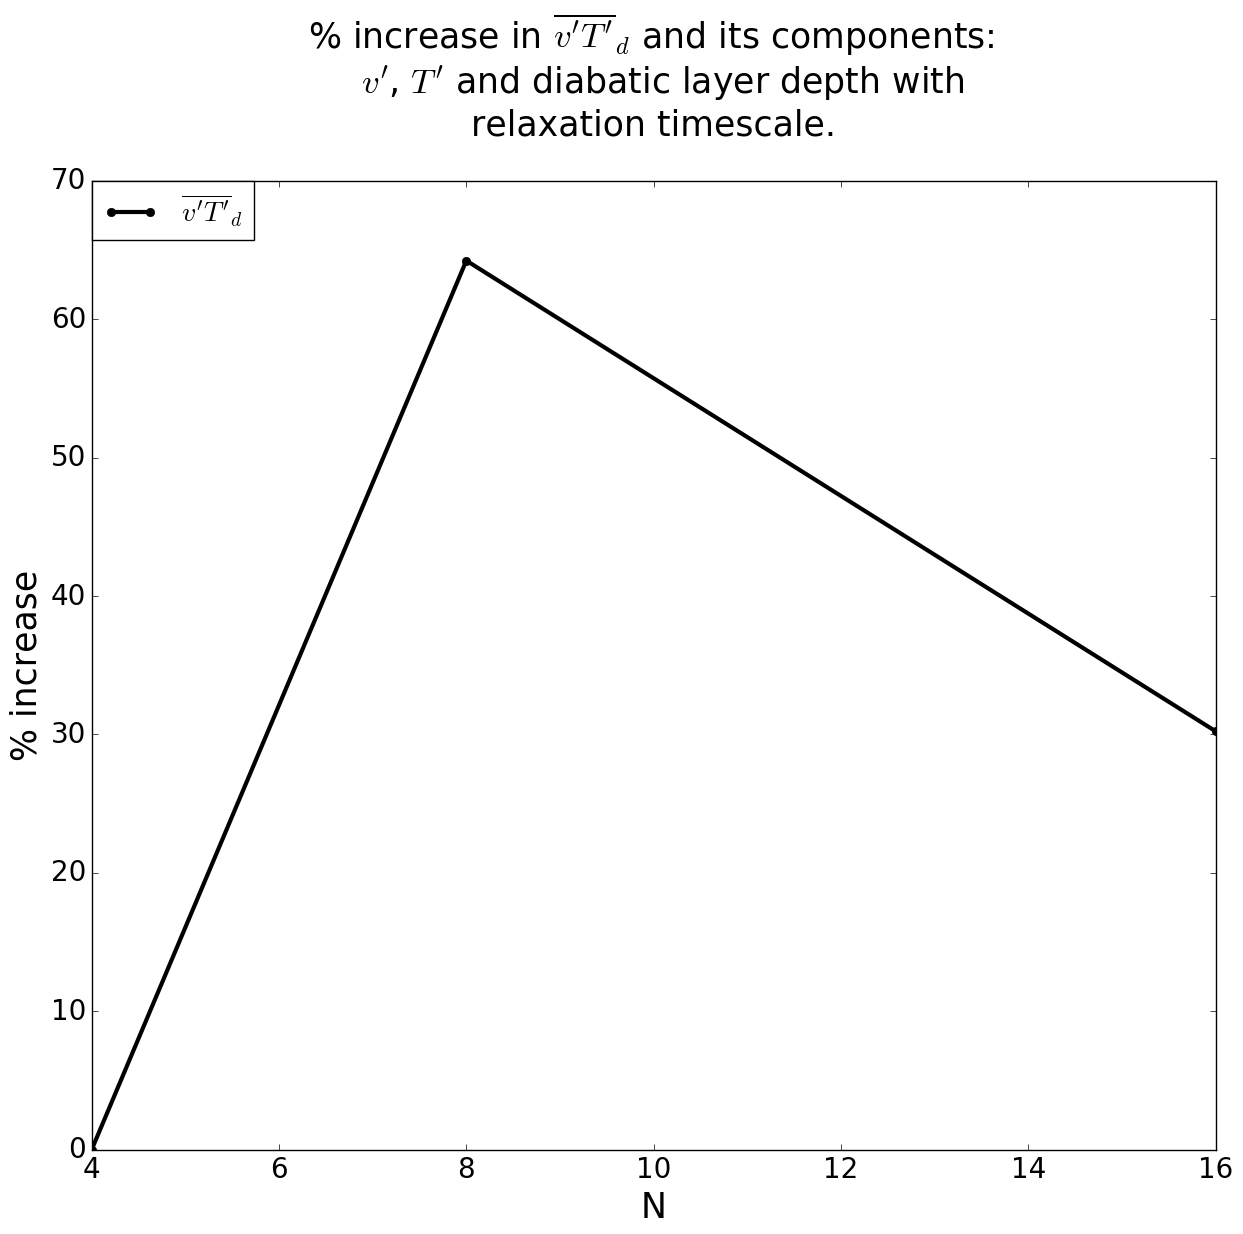

In [67]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = [4,8,16]
p = plot(Tau,np.array(np.array(DE)*100),'-ko',linewidth=3)
#ylim(0,1.2)
#plt.xscale("log")
#plt.xlim(0,1.1*10**4)
xticks(fontsize=20)
yticks(fontsize=20)
xlabel(r'N', fontsize=25)
ylabel(r'% increase', fontsize=25)
title("% increase in $\overline{v^\prime T ^\prime}_{d}$ and its components: \n  $v ^\prime$, $T ^\prime$ and diabatic layer depth with \n relaxation timescale. \n",fontsize=25)
lgd = plt.legend([r'$\overline{v^\prime T ^\prime}_{d}$'], loc=2, borderaxespad=0.,fontsize=20)

KeyError: 'UVELSQ'

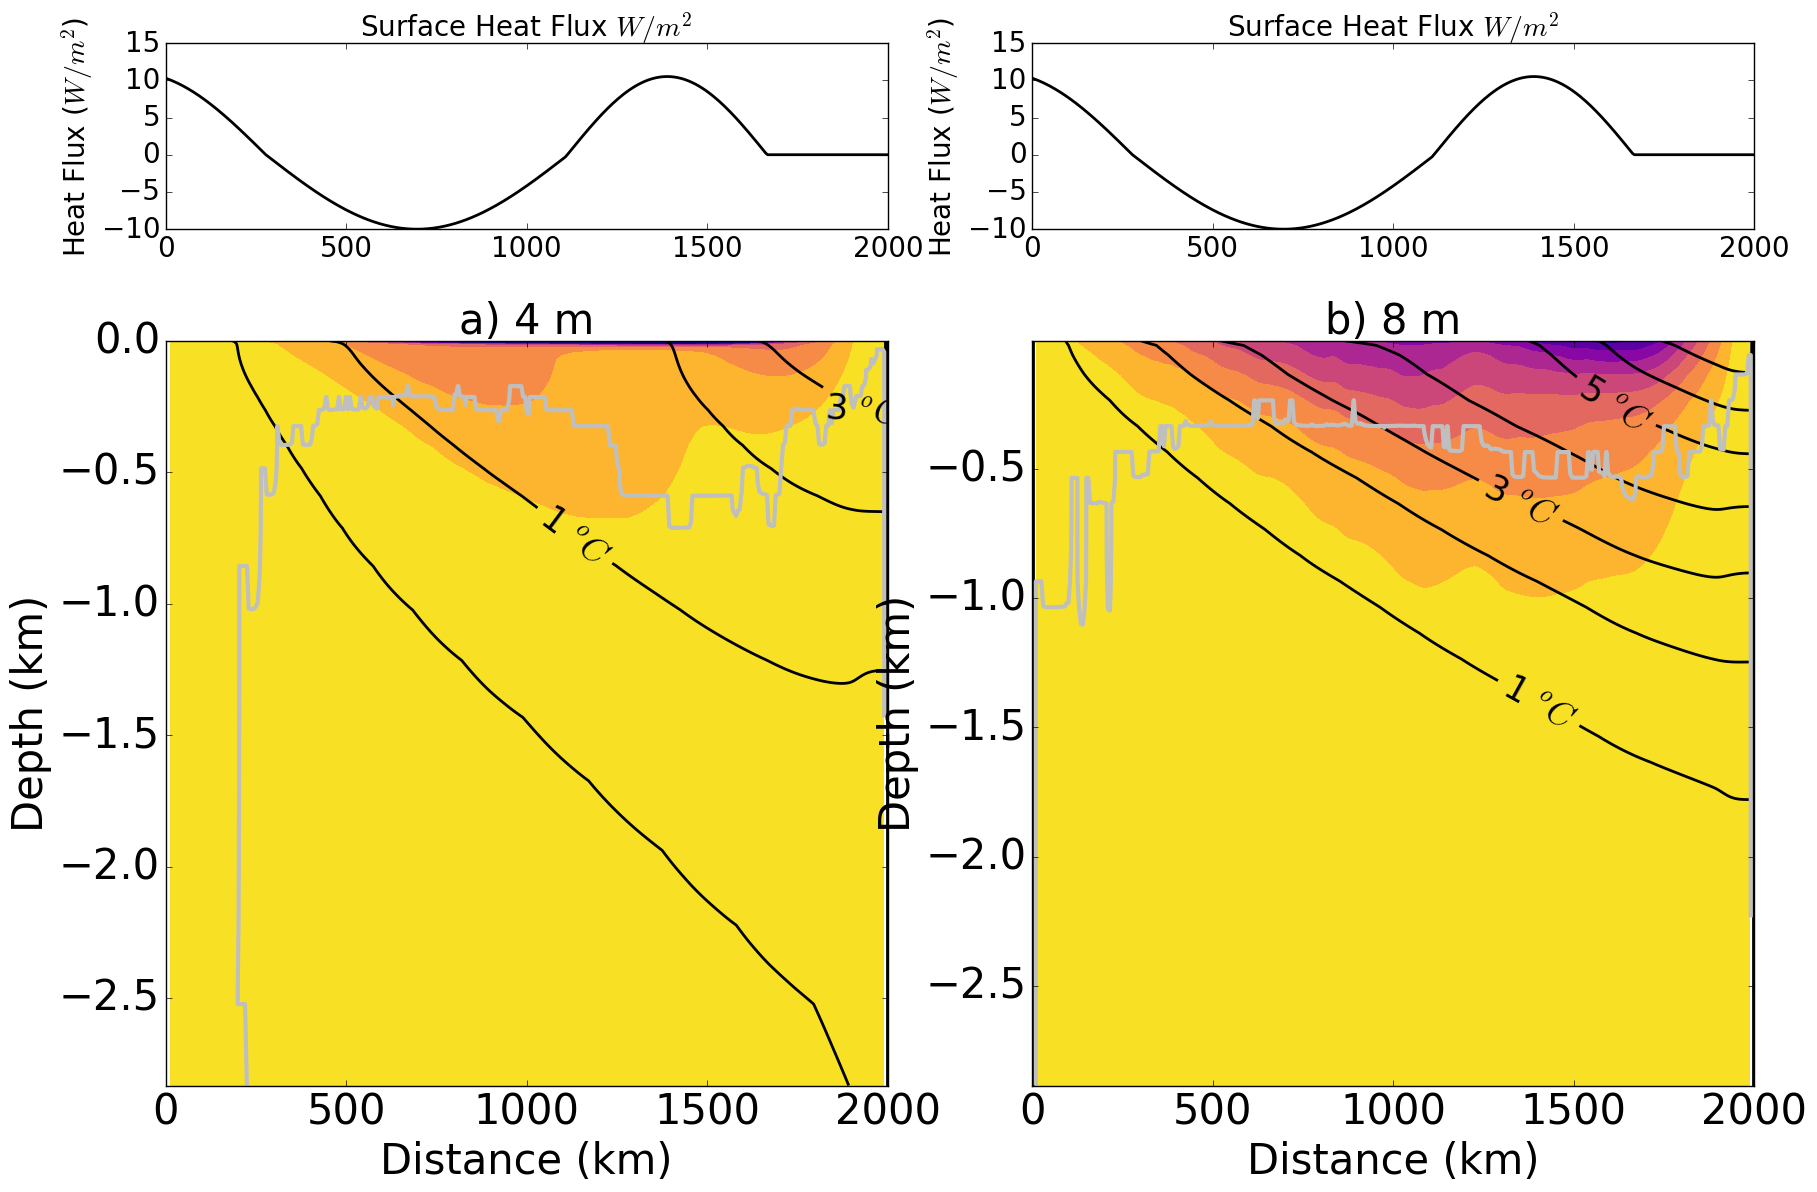

In [50]:
fig = plt.figure(figsize=(20.5, 24.5))
# Create Panels
EKEt = []
EKEt2 = []
Psi_levs = np.arange(-0., .10, .010)
Psi_ticks = np.arange(-0., .10, .02)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
#Q = c.mnc('SURF.nc', 'oceQnet').mean(axis=0).mean(axis=1)
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 4, 4])
ax = plt.subplot(gs[0])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax = plt.subplot(gs[1])
ax.plot(c.yc/1000, -Q, color='k', linewidth=2)
ax.set_title('Surface Heat Flux $W/m^2$', fontsize=20)
ax.set_ylabel('Heat Flux ($W/m^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
for i in range(len(Runs)):
    #i=1
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    EKE = c.calc_EKE()
    CellVol = 5000*5000*1000*np.tile(c.dzf,(c.Nx,c.Ny,1)).T/c.Nx
    EKE1 = c.calc_EKE_all()*CellVol
    EKE1 = np.sum(EKE1,axis=2)
    EKEt.append(np.sum(EKE1))
    EKEt2.append(np.sum(c.calc_EKE_all()))
    ax = plt.subplot(gs[2+i])
    Q2_levs = (np.arange(-1, 8, 1))
    p = ax.contourf(c.yc/1000, c.zc/1000,
                    EKE, Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    Tavlat = c.get_zonal_avg('Tav.nc', 'THETA')
    q = ax.contour(c.yc/1000, c.zc/1000, Tavlat, Q2_levs,
                   colors='k', linewidths=2)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI, PI < 0.95)
    # Depths
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1], axis=0)[::-1]
    g = layers_calc_numba.LayersComputer(c)
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI, th)
    PIz[-5::, 50::] = np.nan
    # Add diabatic layer depth
    r = ax.contour(c.yg/1000, c.zc/1000, PIz, [0.99999999],
                   colors='0.75', linewidths=3)

    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=25)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel('EKE $(m^2s^{-2})$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)
EKET = np.array(EKEt)
EKET2 = np.array(EKEt2)

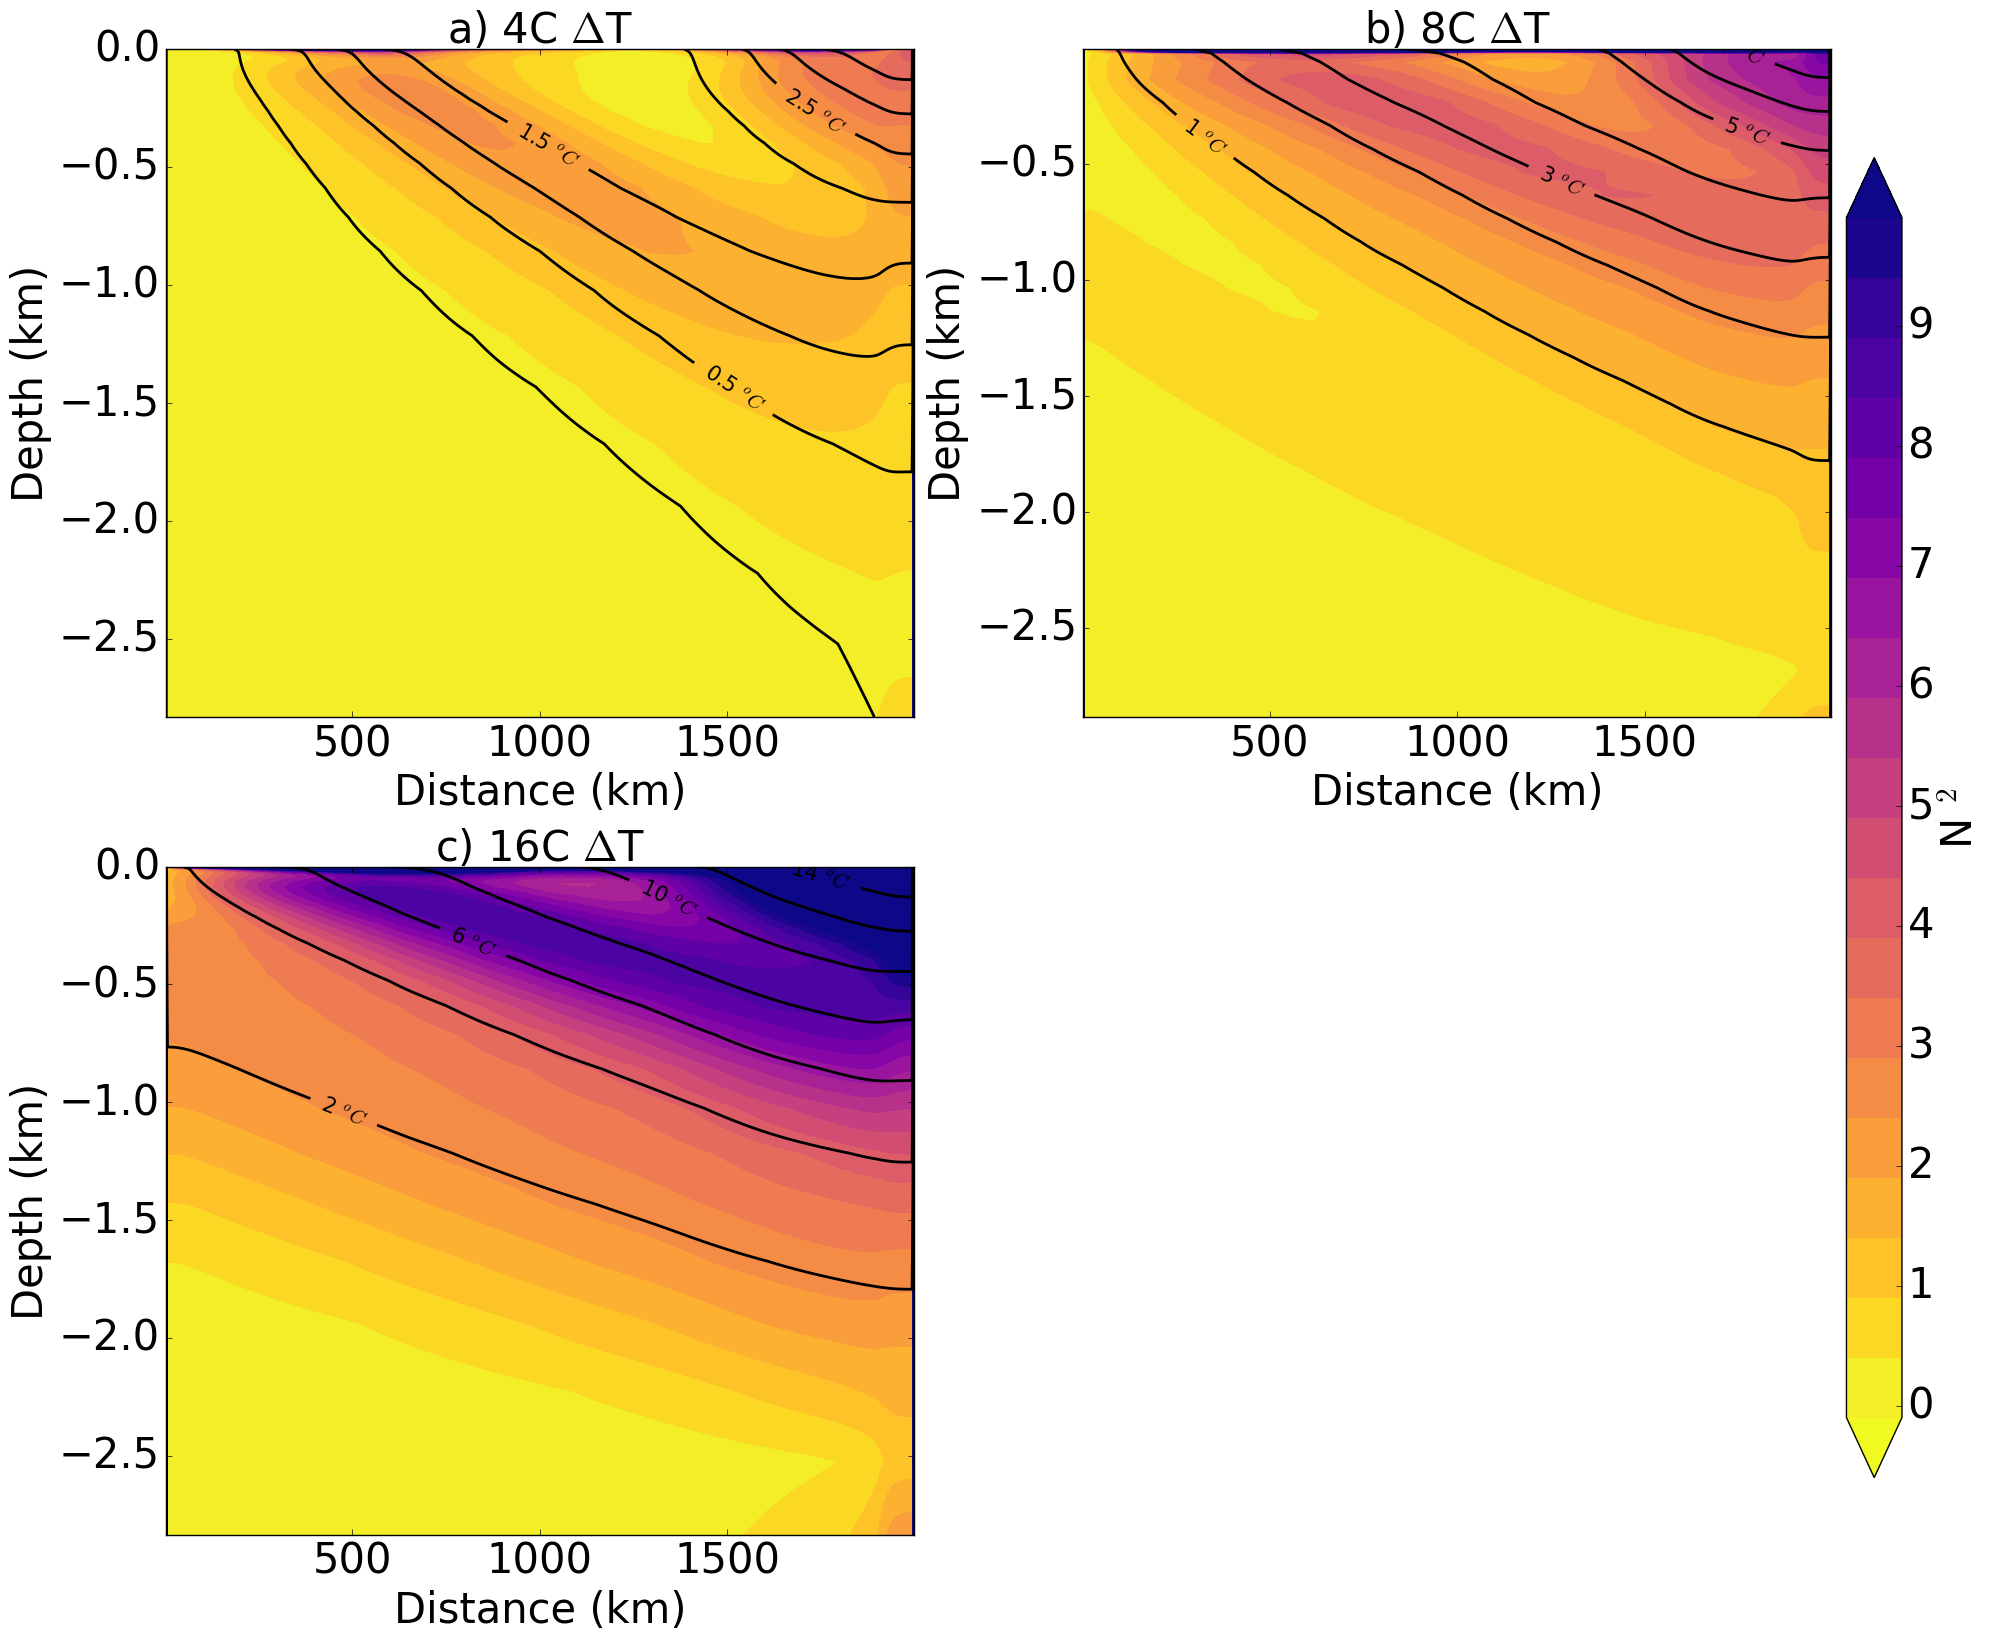

In [60]:
fig = plt.figure(figsize=(18.5, 16.5))
# Create Panels
Psi_levs = np.arange(-.1, 10, .5)
Psi_ticks =np.arange(0, 10, 1)
Eddy_ticks = (np.arange(-3, 1, .5))
E_levs = np.arange(-3., 1, .25)
Q_levs = np.arange(-0.5,4.5,0.5),np.arange(-1,8,1),np.arange(-2,16,2),np.arange(-1,8,1),arange(-1,8,1),arange(-1,8,1),arange(-1,8,1)
for i in range(len(Runs)):
    #i =2 
    fname = x+'/'+str(tau[Runs[i]])+'CDT/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    
    N2 = c.get_N2()
    ax = fig.add_subplot(2, 2, i+1)
    
    p = ax.contourf(c.yc/1000, c.zc/1000,
                N2*10**6,  Psi_levs, cmap=plt.cm.plasma_r, extend='both')
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc','THETA'), Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
 
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'C $\Delta $T', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks = Psi_ticks)
cbar.ax.set_ylabel('N $^2$', fontsize=30, )
cbar.ax.tick_params(labelsize=30)